[View in Colaboratory](https://colab.research.google.com/github/Rblivingstone/iMaterialist_Kaggle_competition/blob/master/notebook.ipynb)

In [1]:
!pip install kaggle
import keras
import pandas as pd
import numpy as np

You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Using TensorFlow backend.


In [2]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)
 



Download 100%.


In [3]:
!kaggle competitions download -c imaterialist-challenge-fashion-2018 -w

test.json.zip: Skipping, found more recently modified local copy (use --force to force download)
validation.json.zip: Skipping, found more recently modified local copy (use --force to force download)
train.json.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
from shutil import unpack_archive
unpack_archive('train.json.zip')


In [5]:
import json
print('okay')
json_data=open('train.json').read()
print('cool')
data = json.loads(json_data)
print(data['images'])

okay
cool


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [0]:
urls = [obj['url'] for obj in data['images']]
ids = [obj['imageId'] for obj in data['images']]

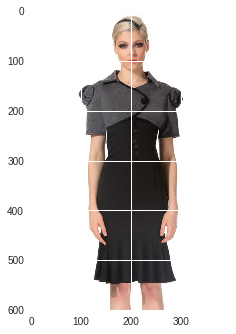

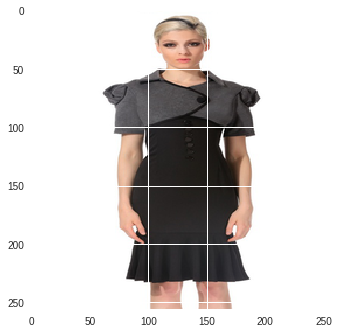

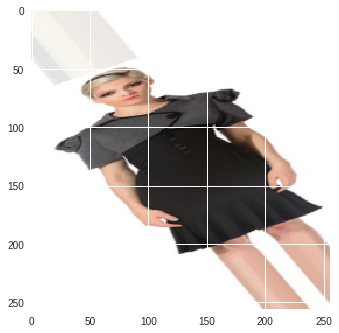

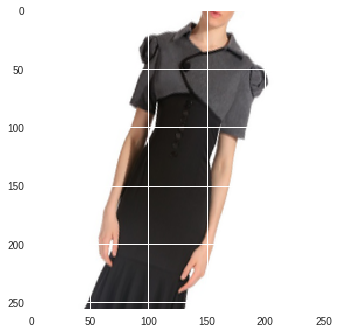

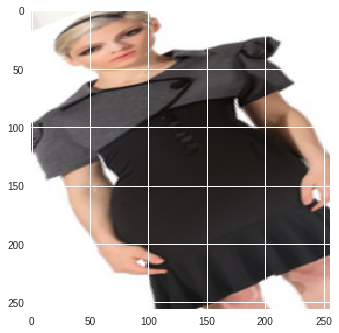

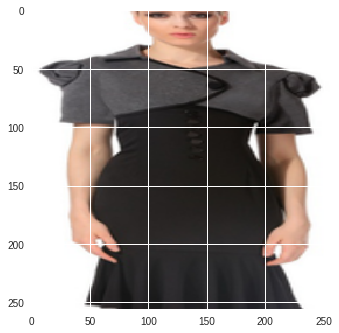

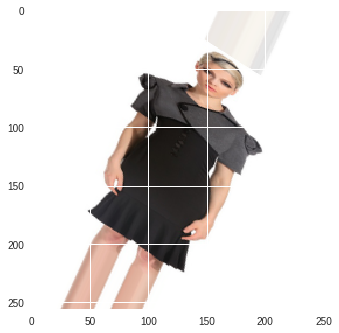

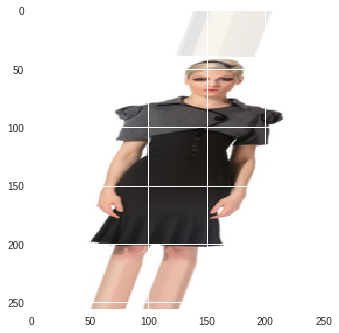

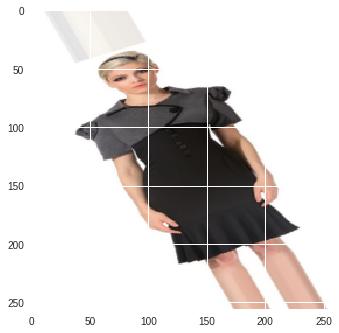

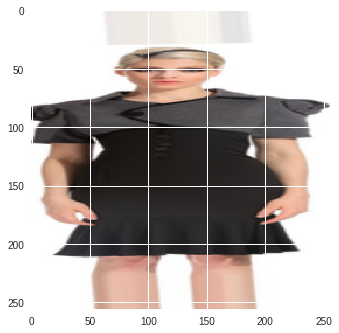

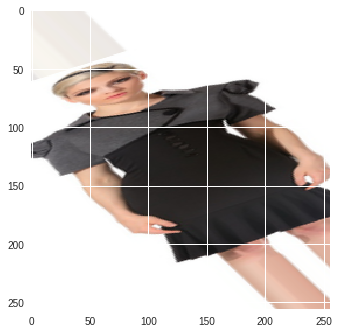

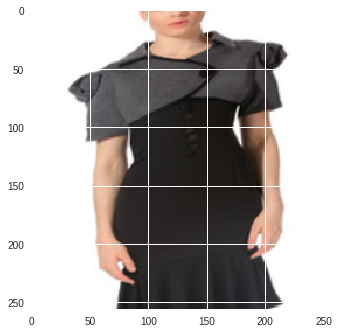

In [7]:
from urllib.request import urlopen	
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
#import StringIO
size=(256,256)
idg = ImageDataGenerator(rescale=1./255,
                        horizontal_flip=True,
                        zoom_range=0.5,
                        shear_range=15,
                        rotation_range=25
                        )
img_file = urlopen(urls[137])
#im_str = StringIO(img_file.read())
I = np.asarray(Image.open(img_file))
plt.imshow(I)
plt.show()

img_file = urlopen(urls[137])
#im_str = StringIO(img_file.read())
im = Image.open(img_file)
im2 = im.resize(size, Image.ANTIALIAS)
im2.thumbnail(size, Image.ANTIALIAS)
I = np.asarray(im2)
plt.imshow(I)
plt.show()
idg_flow = idg.flow(I.reshape(1,256,256,3), batch_size=32)
for i in range(10):
  plt.imshow(idg_flow.next()[0])
  plt.show()

In [8]:
import numpy as np
output = []
for dat in data['annotations']:
  temp = [0]*228
  for obj in dat['labelId']:
    temp[int(obj)-1] = 1
  output.append(temp)
depvar = np.array(output)
print(depvar)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Reshape
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten
from keras.optimizers import SGD,Adamax
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image

def discriminator_model():
    model = Sequential()
    model.add(
            Conv2D(64, (5, 5),
            padding='same',
            input_shape=(256, 256, 3))
            )
    #model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(4, 4)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (5, 5)))
    #model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(4, 4)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (5, 5)))
    #model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(4, 4)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(512))
    #model.add(Activation('relu'))
    model.add(Dense(512))
    #model.add(Activation('relu'))
    model.add(Dense(228))
    #model.add(Activation('sigmoid'))
    print(model)
    return model
  


In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
from keras.models import load_model
model = drive.CreateFile({'id': '1EHMbz_Vk7KTW1U4oMzoPUr4xGyZMN0WG'})
model.GetContentFile('model.h5')
d = load_model('model.h5')
#d = load_model('model.h5')
def generate_labels(array):
  output = []
  for row in array:
    temp = []
    for i in range(228):
      if row[i]>=0.5:
        temp.append(i+1)
    output.append(temp)
  return(output)

def convert_pic_to_data(url):
  try:
    img_file = urlopen(url)
    im = Image.open(img_file)
    
  except:
    output = [0]*(256*256*3)
    output = np.array(output).reshape(1,256,256,3)
    return(output)
    
  im2 = im.resize(size, Image.ANTIALIAS)
  im2.thumbnail(size, Image.ANTIALIAS)
  output = np.asarray(im2)
  return(output.reshape(1,256,256,3))

def label_maker(lookup_range=(0,1)):
  output = []
  for i in range(lookup_range[1]-lookup_range[0]):
    output.append({'id':i+1,'labels':generate_labels(d.predict(convert_pic_to_data(urls[lookup_range[0]+i])))})
  return(output)

#print(label_maker((5,10)))

In [22]:
from google.colab import files
from keras.models import load_model
model = drive.CreateFile({'id': '1EHMbz_Vk7KTW1U4oMzoPUr4xGyZMN0WG'})
model.GetContentFile('model.h5')
d = load_model('model.h5')
#d = discriminator_model()

d_optim = Adamax()
d.compile(loss='mean_absolute_error', optimizer=d_optim)

idg = ImageDataGenerator(rescale=1./255,
                        horizontal_flip=True,
                        zoom_range=0.5,
                        shear_range=15,
                        rotation_range=25
                        )
#np.random.seed(1825)
t=0
size = (256,256)

x=np.array([])
y=np.array([])
for j in range(len(urls)):
  #print(j)
  pix = j

  try:
    img_file = urlopen(urls[pix])
    im = Image.open(img_file)
  except:
    next
  im2 = im.resize(size, Image.ANTIALIAS)
  im2.thumbnail(size, Image.ANTIALIAS)
  I = np.asarray(im2)
#plt.imshow(I)
#plt.show()
  idg_flow = idg.flow(I.reshape(1,256,256,3),np.array(depvar[pix]).reshape(1,228), batch_size=32)
  for i in range(32):
    tempx,tempy = idg_flow.next()
    x = np.append(x,tempx[0])
    y = np.append(y,tempy[0])
d.fit(x.reshape(32*len(urls),256,256,3),y.reshape(320,228),epochs=100)
t+=1

#if t%1000==0:
plt.imshow(I)
plt.show()
d.save('model.h5')
print(generate_labels(d.predict(I.reshape(1,256,256,3))))
print(np.sort([int(obj) for obj in data['annotations'][pix]['labelId']]).tolist())
model.SetContentFile('model.h5')
model.Upload()
#  files.download('model.h5')
    

InvalidConfigError: ignored

In [20]:
depvar[np.argmax(np.sum(depvar,axis=1))]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 0])